In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

**Dataset**

The ‘TennisAbstract’ website and its associated blog ‘Heavy Topspin’ are resources made available for free by tennis enthusiast Jeff Sackmann. The source is widely referenced in both academic papers (Kovalchik Stephanie, 2016) and in less formal analyses by members of the tennis community and is regularly maintained. The raw data that they link to contains 
information on all ATP tournaments going all the way back to 1968 (start of the open era) in an easily downloadable format and contains the following fields:

In [156]:
''' 
Function to import data from github. Date range must be valid per the given URL
'''

def import_data(start_date: int, end_date: int):
    li = []
    for year in range(start_date, end_date, 1):
        url = f'https://raw.githubusercontent.com/JeffSackmann/tennis_atp/refs/heads/master/atp_matches_{year}.csv'
        data = pd.read_csv(url, header=0)

        li.append(data)

    frame = pd.concat(li, axis=0, ignore_index=True)
    return frame

In [157]:
df = import_data(2010, 2019)
print('Shape:', df.shape)
df.head(5)

Shape: (26591, 49)


,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,20100103,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,20100103,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,20100103,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,20100103,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,20100103,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


**The following actions were taken to clean the data ahead of analysis:**

•   Dates were standardized using the datetime package.

•   Matches with empty data fields were removed.

•   Abandoned matches were removed by deleting games with fewer than 24 service points from winner and loser.

•   Matches with missing ‘handedness’ were removed

•   Missing height data was replaced with average height for winner / loser. This is clearly a large assumption but with so many players not having any height data the alternative was to remove them all and it was felt that this would remove too much valuable information from the dataset.

•   Players with missing age data were removed.

•   Players without rank data were removed.

•   Matches with no surface data were removed

•   Players who had played less than 5 games at ATP level during the study were removed. This was done to address the fact that many of the players on the ATP tour are on the fringes of this level of the game. Places at local tournaments are often secured for local players who are not up to the standard of the other competitors. Players in this category are outliers in the sense that they only manage a handful of games at this level throughout their careers and therefore there is limited data on each of them to have a meaningful impact on a predictive model. The removal of players with fewer than 5 competitive matches at this level over the period of the data is qualitative attempt to ‘clean’ the data of these contributions. 
 


In [158]:

'''
Perform data 'cleaning' operations on raw dataframe. List of transformations can be found 
in the precedint markdown cell but in general the goal is to homogenise the dataframe with a 
goal of modelling contests with similar characteristics
'''


def clean_data(df):
    ### Reformat dates using datetime
    df['tourney_date'] = pd.to_datetime(df['tourney_date'], format='%Y%m%d')
    ### Restrict analysis to hard courts 
    df = df[df['surface'] == 'Hard']
    ### Remove matches with significant missing data (use 'winner aces' here but could use any of missing fields)
    df = df.dropna(subset=['w_ace'])
    ### Remove abandoned matches - fewer than 24 serves.
    df = df[df['w_svpt'].gt(24) | df['l_svpt'].gt(24)]
    ### Remove matches where 'handedness of one or other players is missing or n/a
    df = df.dropna(subset=['winner_hand', 'loser_hand'])
    ### Replace missing height data with average height
    df['loser_ht'] = df['loser_ht'].fillna(df['loser_ht'].mean())
    df['winner_ht'] = df['winner_ht'].fillna(df['winner_ht'].mean())
    ### Remove entries with missing rank data
    df = df.dropna(subset=['winner_rank', 'loser_rank'])


    return df

In [159]:
df = clean_data(df)

In [161]:
df.shape

(13825, 49)

Now consider players who've not played many times over the relevant period...

In [195]:
### Create df of players with their win totals
def player_record(df):
    players = np.union1d(pd.unique(df['winner_name']), pd.unique(df['loser_name']))
    df_matches = pd.DataFrame(['Player', 'W matches', 'L matches', 'Total matches'])
    dict_list = []

    for player in players:
        row_dict = {'Player': player, 
                    'W matches': 0 if player not in df['winner_name'].value_counts() else df['winner_name'].value_counts()[player], 
                    'L matches': 0 if player not in df['loser_name'].value_counts() else df['loser_name'].value_counts()[player],
                    'Total matches': 0
                    }
        dict_list.append(row_dict)
    df_matches = pd.DataFrame.from_dict(dict_list)
    df_matches['Total matches'] = df_matches['W matches'] + df_matches['L matches']

    return df_matches

In [213]:
# list of all playerw with number of matches won / lost / played
record = player_record(df)
record_sub_5 = record.loc[record['Total matches'] < 5, 'Player']

Seems a bit high (350 / 703)... but clearly lots of players only play < 5 matches at this level

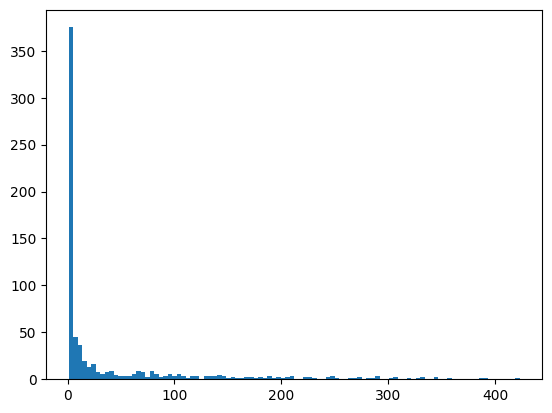

In [209]:
plt.hist(record['Total matches'], bins=100)
plt.show() 

Let's remove these players from the main dataframe and see how things look...

In [216]:
# list of player names who've played fewer than 5 times on the ATP tour in the given time period
sub_5_list = record_sub_5.to_list()

In [221]:
# remove these players from the dataframe
df = df[~df['winner_name'].isin(sub_5_list) | ~df['loser_name'].isin(sub_5_list)]

In [222]:
df.head()

,tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,...,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
0,2010-339,Brisbane,Hard,32,A,2010-01-03,1,104053,1.0,NaN,...,34.0,29.0,11.0,10.0,3.0,5.0,7.0,4410.0,77.0,598.0
1,2010-339,Brisbane,Hard,32,A,2010-01-03,2,104958,NaN,WC,...,34.0,22.0,14.0,9.0,7.0,10.0,134.0,400.0,78.0,590.0
2,2010-339,Brisbane,Hard,32,A,2010-01-03,3,104755,NaN,NaN,...,58.0,38.0,14.0,14.0,7.0,11.0,52.0,850.0,88.0,568.0
3,2010-339,Brisbane,Hard,32,A,2010-01-03,4,105051,NaN,Q,...,29.0,16.0,15.0,9.0,2.0,5.0,285.0,151.0,28.0,1260.0
4,2010-339,Brisbane,Hard,32,A,2010-01-03,5,104607,4.0,NaN,...,41.0,26.0,14.0,9.0,6.0,9.0,20.0,1655.0,251.0,179.0


In [223]:
df.shape

(13775, 49)